In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/anode")
import anode

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bgflow.utils import (assert_numpy, length_ppp, 
                          remove_mean, IndexBatchIterator, LossReporter, as_numpy, compute_distances, distance_vectors, distances_from_vectors, length_ppp
)
from bgflow import (GaussianMCMCSampler, DiffEqFlow, BoltzmannGenerator, Energy, Sampler, 
                    MultiDoubleWellPotential, MeanFreeNormalDistribution, KernelDynamics)

from glob import glob

In [4]:
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.*.lammpstrj')
#fnames = fnames + glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.0000020000.lammpstrj')
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.0000000000.lammpstrj')
#arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
#coordinates = np.array(arrays)
temperature = float(0.1)
side = 3.
n_particles = 4 #len(coordinates[0])
spacial_dim = 2
dim_ics = n_particles * spacial_dim
#coordinates=coordinates.reshape(len(arrays), dim_ics)

In [5]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP
from  bgflow.distribution.energy import LennardJonesPotential
rm = 2**(1./6.)
#target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm, two_event_dims=False)
target = LennardJonesPotential(dim = dim_ics, n_particles = n_particles,oscillator = False,  two_event_dims=False)

In [6]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [7]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [68]:
# define a MCMC sampler to sample from the target energy

#init_state = torch.Tensor([-0.5,-0.5,-0.5,0.5,0.5,-0.5,0.5,0.5])
init_state = torch.Tensor([-0.5,0, 0.5,0, 0, 0.5, 0, -0.5])

mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature,  noise_std=0.03)

In [69]:
mcsampler.sample(5000)
data = mcsampler.sample(8192)
data = remove_mean(data, n_particles, spacial_dim)
data = data.view(-1,dim_ics)

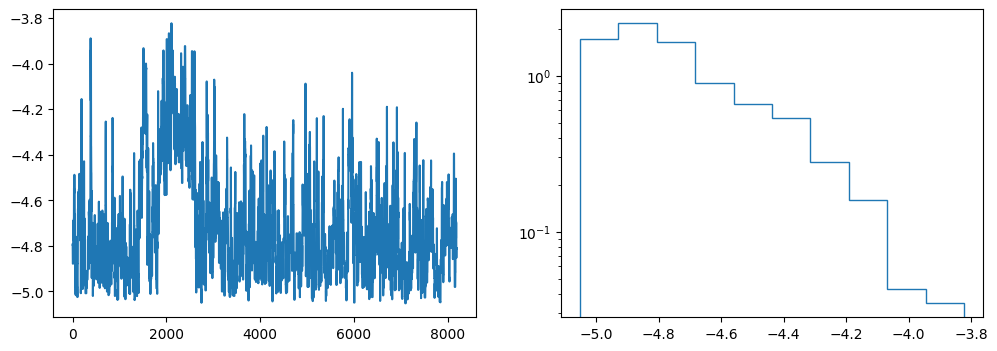

In [70]:
plot_energy(data, target)

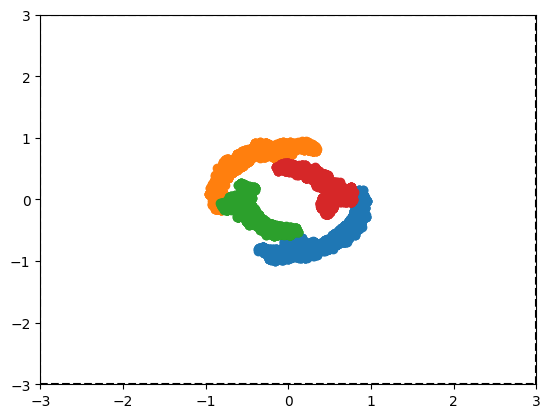

In [71]:
plt.xlim(-side,side)
plt.ylim(-side,side)
datanp = data.detach().cpu().numpy()
plt.scatter(datanp[:,0], datanp[:,1])
plt.scatter(datanp[:,2], datanp[:,3])
plt.scatter(datanp[:,4], datanp[:,5])
plt.scatter(datanp[:,6], datanp[:,7])
plt.plot([-side,-side], [-side,side], linestyle="--", color='black')
plt.plot([side,side], [-side,side], linestyle="--", color='black')
plt.plot([-side,side], [-side,-side], linestyle="--", color='black')
plt.plot([-side,side], [side,side], linestyle="--", color='black')

In [12]:
# now set up a prior

from bgflow import NormalDistribution, TruncatedNormalDistribution, MeanFreeNormalDistribution, CircularNormalDistribution

prior =  MeanFreeNormalDistribution(dim_ics, n_particles, std=1.,two_event_dims=False) #.cuda()

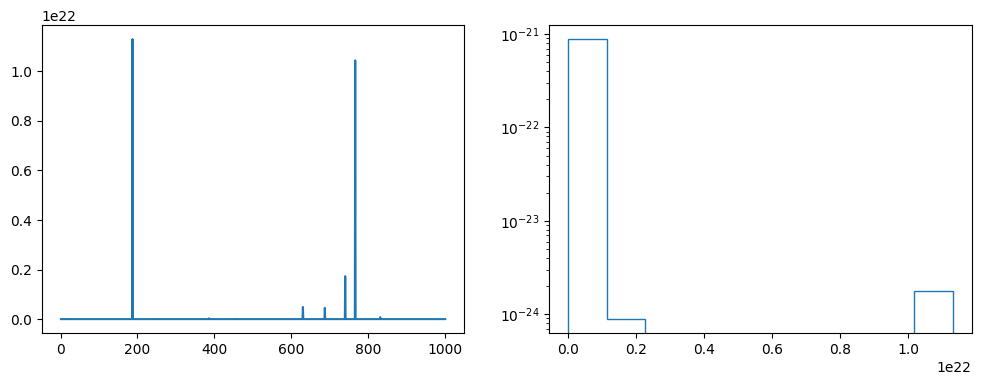

In [13]:
data_prior = prior.sample(1000, temperature=temperature)
#data_prior = prior.sample(1000)
#data_prior = data_prior.view(-1, 10, 3)
plot_energy(data_prior, target)

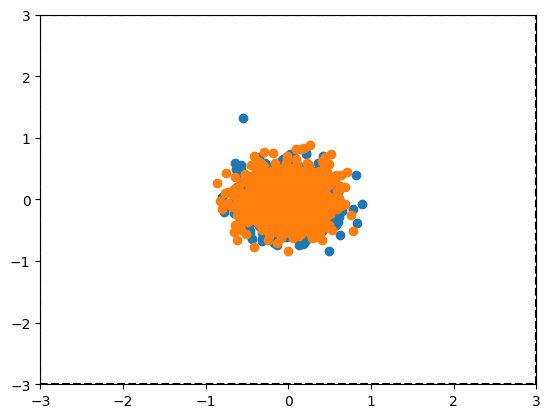

In [14]:
plt.xlim(-side,side)
plt.ylim(-side,side)
plt.scatter(data_prior[:,0], data_prior[:,1])
plt.scatter(data_prior[:,2], data_prior[:,3])
#plt.scatter(data_prior[:,4], data_prior[:,5])
#plt.scatter(data_prior[:,6], data_prior[:,7])
plt.plot([-side,-side], [-side,side], linestyle="--", color='black')
plt.plot([side,side], [-side,side], linestyle="--", color='black')
plt.plot([-side,side], [-side,-side], linestyle="--", color='black')
plt.plot([-side,side], [side,side], linestyle="--", color='black')

In [15]:
# set of the equivariant kernel dynamics

n_dimensions = spacial_dim
d_max = 8
mus = torch.linspace(0, d_max, 50) #.cuda()

mus.sort()
gammas = 0.3 * torch.ones(len(mus)) #.cuda()

mus_time = torch.linspace(0, 1, 10) #.cuda()
gammas_time = 0.3 * torch.ones(len(mus_time)) #.cuda()


kdyn = KernelDynamics(n_particles, n_dimensions, mus, gammas, optimize_d_gammas=True, optimize_t_gammas=True,
                      mus_time=mus_time, gammas_time=gammas_time, periodic = False)#, side = side) #.cuda()


In [16]:
flow = DiffEqFlow(dynamics = kdyn)

In [17]:
# having a flow and a prior, we can now define a Boltzmann Generator

bg = BoltzmannGenerator(prior, flow, target) #.cuda()

In [18]:
n_samples = 2000
samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True, temperature=temperature)
log_w = as_numpy(bg.log_weights_given_latent(samples, latent, dlogp, temperature=temperature))

/home/ninarell/miniconda3/envs/bg/lib/python3.10/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'temperature': 0.1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


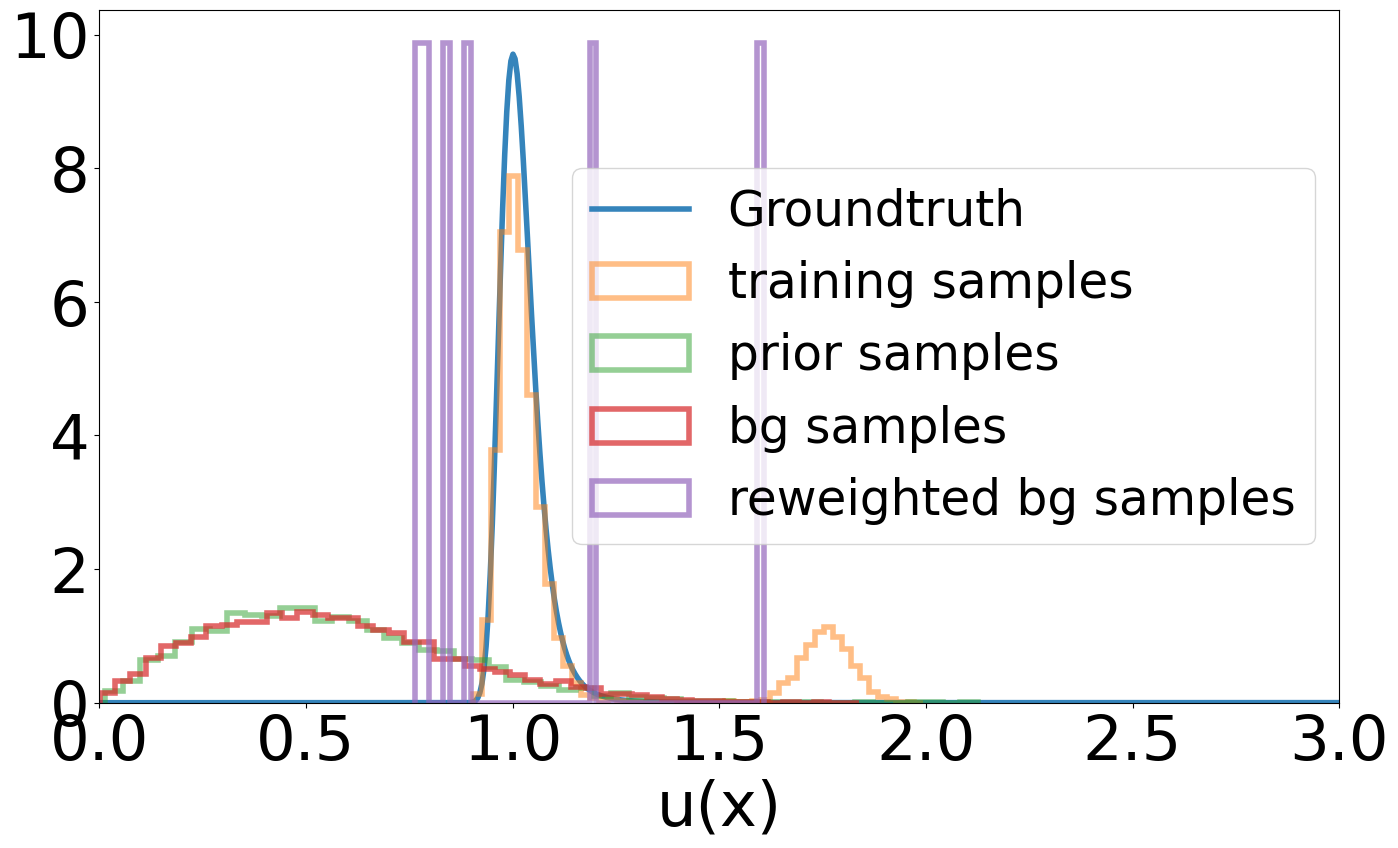

In [19]:
def lennard_jones_energy_torch(r, eps=1.0, rm=1.0):
    lj = eps * ((rm / r) ** 12 - 2 * (rm / r) ** 6)
    return lj
d = torch.linspace(0, 5, 1000).view(-1, 1) + 1e-6 
u = torch.exp(-(lennard_jones_energy_torch(d).view(-1, 1))/(temperature*1)).sum(dim=-1, keepdim=True)  * d.abs() **(dim_ics // n_particles - 1)
Z = (u * 1 / (len(d) / (d.max() - d.min()))).sum()
e = u / Z 

plt.figure(figsize=(16,9))

distances_x = as_numpy(compute_distances(samples,  n_particles, n_dimensions))
dists_data = as_numpy(compute_distances(data,  n_particles, n_dimensions))
dists_data_prior = as_numpy(compute_distances(data_prior,  n_particles, n_dimensions))

plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.9)
plt.hist(dists_data.reshape(-1), bins=50, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(dists_data_prior.reshape(-1), bins=50, label="prior samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_x.reshape(-1), bins=50, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);

repeat_counts = (len(distances_x)* np.exp(log_w)/np.sum(np.exp(log_w))).astype(int)
distances_x = np.repeat(distances_x, repeat_counts, axis=0)
log_w_weigthed = np.repeat(log_w, repeat_counts)
log_w_weigthed =  np.repeat(log_w_weigthed, distances_x.shape[1])
plt.hist(distances_x.reshape(-1), bins=50, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(log_w_weigthed));

plt.xlim(0,3)
plt.legend(fontsize=35)
plt.xlabel("u(x)", fontsize=45)  
plt.xticks(fontsize=45) 
plt.yticks(fontsize=45);

In [20]:
# use DTO in the training process
flow._use_checkpoints = True

# Anode options
options={
    "Nt": 20,
    "method": "RK4"
}
flow._kwargs = options

In [21]:
# initial training with likelihood maximization on data set

n_kl_samples = 64
n_batch = 64
batch_iter = IndexBatchIterator(len(data), n_batch)

lr=2e-3

optim = torch.optim.Adam(bg.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 3
n_report_steps = 4

# mixing parameter
lambdas = torch.linspace(1., 0.1, n_epochs) #.cuda()

reporter = LossReporter("NLL", "KLL")

2024-05-24 15:06:22.653351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 15:06:22.653379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 15:06:22.654407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 15:06:22.659807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 15:06:23.327302: W tensorflow/compiler/tf2

In [22]:
for epoch, lamb in enumerate(lambdas):
    for g in optim.param_groups:
            g['lr'] = lr * np.exp(-10*float(epoch)/float(n_epochs))
            
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs] #.cuda()
        
        

        optim.zero_grad()

        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch, temperature=temperature).mean()
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples, temperature=temperature).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")
    n_samples = 3000
    samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True, temperature=temperature)
    log_w = as_numpy(bg.log_weights_given_latent(samples, latent, dlogp))
    fig = plt.figure(figsize=(16,9))
    distances_x = as_numpy(compute_distances(samples,  n_particles, n_dimensions))
    plt.hist(dists_data.reshape(-1), bins=100, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
    plt.hist(dists_data_prior.reshape(-1), bins=100, label="prior samples", alpha=0.5, density=True, histtype='step', linewidth=4);
    plt.hist(distances_x.reshape(-1), bins=100, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);
    
    repeat_counts = (len(distances_x)* np.exp(log_w)/np.sum(np.exp(log_w))).astype(int)
    distances_x = np.repeat(distances_x, repeat_counts, axis=0)
    log_w_weigthed = np.repeat(log_w, repeat_counts)
    log_w_weigthed =  np.repeat(log_w_weigthed, distances_x.shape[1])
    plt.hist(distances_x.reshape(-1), bins=50, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(log_w_weigthed));
    
    plt.xlim(0,3)
    plt.legend(fontsize=35)
    plt.xlabel("u(x)", fontsize=45)  
    plt.xticks(fontsize=45) 
    plt.yticks(fontsize=45);
    plt.show
    filename = '/home/ninarell/Desktop/FIG_ENERGY/fig_'+str(epoch)+".png"
    fig.savefig(filename, dpi=fig.dpi, format='png')
    plt.close()

epoch: 2, iter: 124/128, lambda: 0.10000000149011612, NLL: 1.045, KLL: 2.974e+129

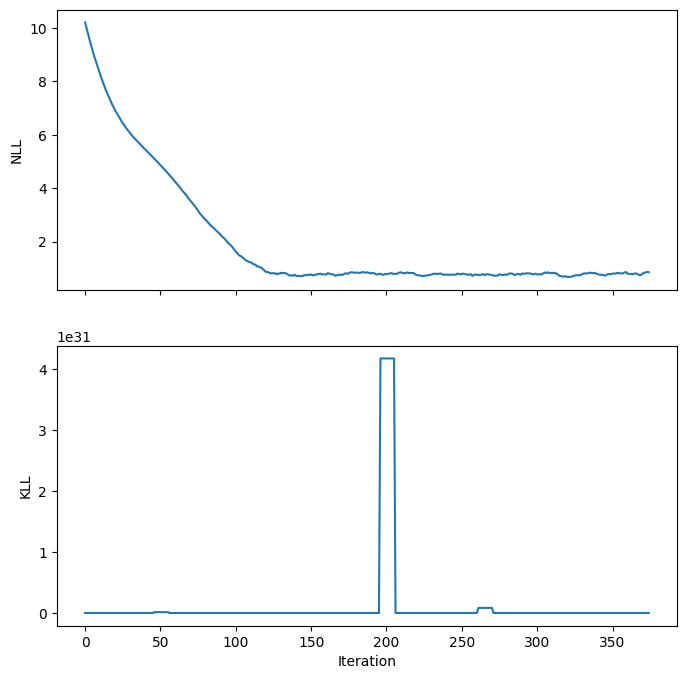

In [23]:
reporter.plot()

In [24]:
# print(log_w.shape)
# print(dlogp.shape)
# print(latent.shape)
# print(samples.shape)
# print(distances_x.shape)
# print(log_w)
# print(distances_x.shape)

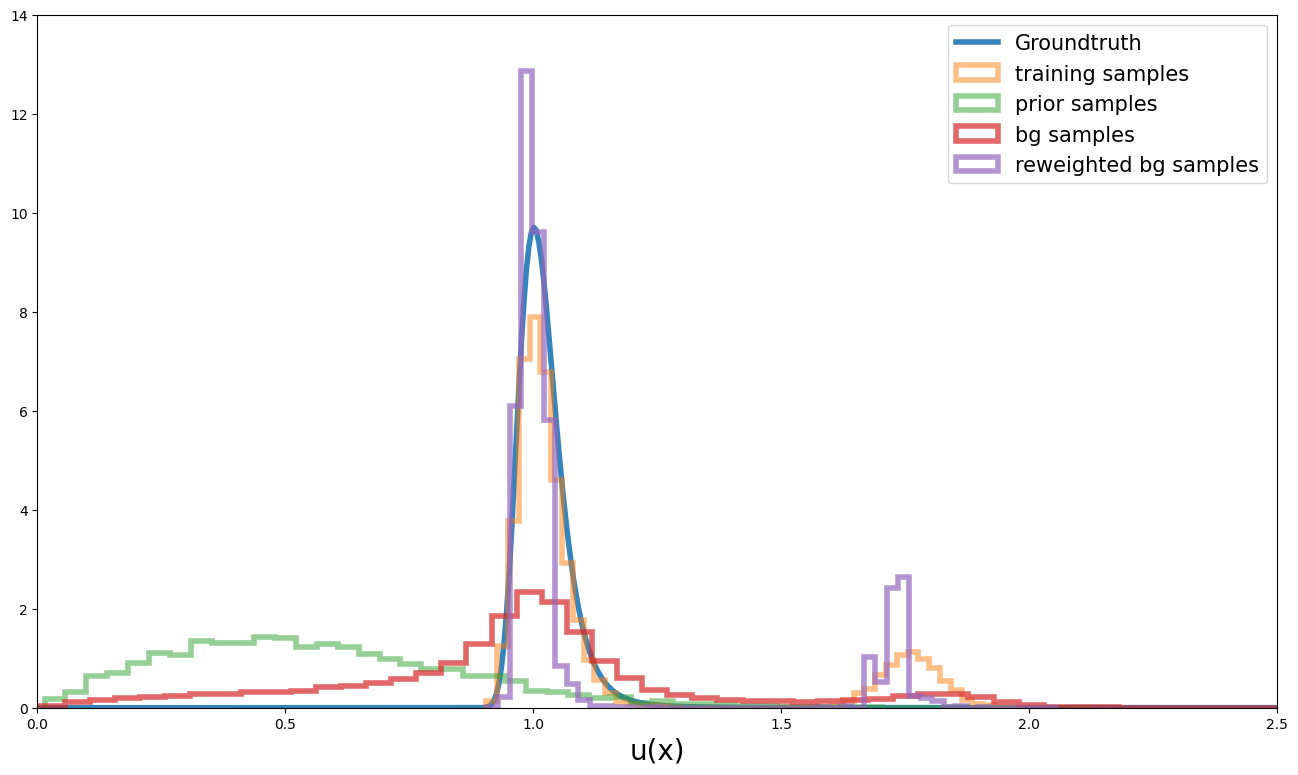

In [56]:
n_samples = 10000
samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True, temperature=temperature)
log_w = as_numpy(bg.log_weights_given_latent(samples, latent, dlogp, temperature=temperature))

distances_x = as_numpy(compute_distances(samples,  n_particles, n_dimensions))

plt.figure(figsize=(16,9))
plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.9)
plt.hist(dists_data.reshape(-1), bins=50, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(dists_data_prior.reshape(-1), bins=50, label="prior samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_x.reshape(-1), bins=50, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);

repeat_counts = (len(distances_x)* np.exp(log_w)/np.sum(np.exp(log_w))).astype(int)
distances_x = np.repeat(distances_x, repeat_counts, axis=0)
log_w_weigthed = np.repeat(log_w, repeat_counts)
log_w_weigthed =  np.repeat(log_w_weigthed, distances_x.shape[1])
plt.hist(distances_x.reshape(-1), bins=50, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(log_w_weigthed));
    

plt.xlim(0,2.5)
plt.ylim(0,14)
#plt.yscale('log') 
plt.legend(fontsize=15)
plt.xlabel("u(x)", fontsize=20)  
plt.xticks(fontsize=10) 
plt.yticks(fontsize=10);

In [48]:
np.where(np.any(distances_x> np.sqrt(side*side*2)))

/tmp/ipykernel_470505/690350246.py:1: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(np.any(distances_x> np.sqrt(side*side*2)))


(array([], dtype=int64),)

In [49]:
repeat_counts = (len(samples)* np.exp(log_w)/np.sum(np.exp(log_w))).astype(int)
samples = samples.view(-1,n_particles, n_dimensions)

In [50]:
samples.detach().cpu().numpy().shape

(30000, 4, 2)

In [51]:
replicated_samples = np.repeat(samples.detach().cpu().numpy(), repeat_counts, axis=0)
replicated_samples = replicated_samples.reshape((replicated_samples.shape[0], -1))

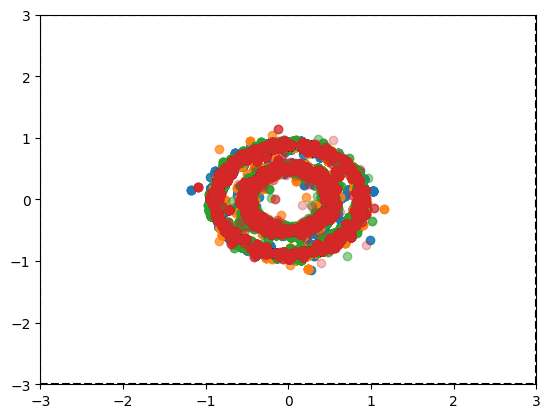

In [59]:
plt.xlim(-side,side)
plt.ylim(-side,side)
plt.scatter(replicated_samples[:,0], replicated_samples[:,1], alpha=.9)
plt.scatter(replicated_samples[:,2], replicated_samples[:,3], alpha=.7)
plt.scatter(replicated_samples[:,4], replicated_samples[:,5], alpha=.5)
plt.scatter(replicated_samples[:,6], replicated_samples[:,7], alpha=.3)
plt.plot([-side,-side], [-side,side], linestyle="--", color='black')
plt.plot([side,side], [-side,side], linestyle="--", color='black')
plt.plot([-side,side], [-side,-side], linestyle="--", color='black')
plt.plot([-side,side], [side,side], linestyle="--", color='black')

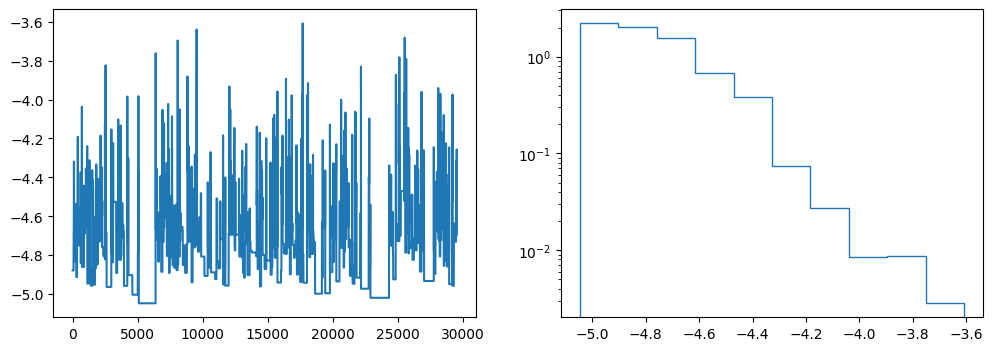

In [53]:
plot_energy(replicated_samples, target)